In [1]:
from gnn import QGNN
import quartz
import torch
import dgl
import random

Using backend: pytorch
[02:14:35] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/zikunli/anaconda3/envs/quantum/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.so: cannot open shared object file: No such file or directory


In [2]:
quartz_context = quartz.QuartzContext(gate_set=['h', 'cx', 'x', 't', 'tdg', 'ccz'], filename='../T_TDG_5_3_complete_ECC_set.json')
parser = quartz.PyQASMParser(context=quartz_context)

In [3]:
# Pretraining using tof_3 circuit
# Preparaing data
from concurrent.futures import ProcessPoolExecutor

xfers_reward = [xfer.src_gate_count - xfer.dst_gate_count for xfer in quartz_context.get_xfers()]
xfers_reward = torch.tensor(xfers_reward, dtype=torch.float)
xfers_reward_mask = xfers_reward > 0

# def get_dataset(i):
#     dag_i = parser.load_qasm(filename=f"barenco_graphs/barenco_tof_3_{i}.qasm")
#     graph = quartz.PyGraph(context=quartz_context, dag=dag_i)
#     dgl_graph = graph.to_dgl_graph()
#     appliable_xfer_matrix = graph.get_available_xfers_matrix(context=quartz_context)
#     appliable_xfer_matrix = torch.tensor(appliable_xfer_matrix, dtype=torch.float)
#     # appliable_xfer_matrix = torch.multiply(appliable_xfer_matrix, 6)
#     # appliable_xfer_matrix = torch.subtract(appliable_xfer_matrix, 5)
#     dgl_graph.ndata['label'] = appliable_xfer_matrix.clone().detach()
#     return dgl_graph

def get_dataset(i):
    dag_i = parser.load_qasm(filename=f"barenco_tof_3_opt_path/subst_history_{i}.qasm")
    graph = quartz.PyGraph(context=quartz_context, dag=dag_i)
    dgl_graph = graph.to_dgl_graph()
    appliable_xfer_matrix = graph.get_available_xfers_matrix(context=quartz_context)
    appliable_xfer_matrix = torch.tensor(appliable_xfer_matrix, dtype=torch.float)
    # appliable_xfer_matrix = torch.multiply(appliable_xfer_matrix, 6)
    # appliable_xfer_matrix = torch.subtract(appliable_xfer_matrix, 5)
    dgl_graph.ndata['label'] = appliable_xfer_matrix.clone().detach()
    return dgl_graph

idx_list = list(range(40))
with ProcessPoolExecutor(max_workers=20) as executor:
    results = executor.map(get_dataset, idx_list, chunksize=2)

opt_path_dgls = [r for r in results]

In [4]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2).mean()

def train_supervised(g, model, lr=0.01, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['gate_type']

    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    num_pos = torch.sum((labels[train_mask] == 1).float())
    num_neg = torch.sum((labels[train_mask] == 0).float())

    weight = labels[train_mask]
    # w_pos = torch.log(num_pos + 1) + 1
    # w_neg = torch.log(num_neg + 1) + 1
    w_pos = (num_neg + num_pos) / num_pos / 2
    w_neg = (num_neg + num_pos) / num_neg / 2
    # w_pos_normalized, w_neg_normalized = w_pos/ (w_pos + w_neg), w_neg / (w_pos + w_neg)
    # print(w_pos_normalized, w_neg_normalized)
    # weight[labels[train_mask] == 1] = w_pos
    # weight[labels[train_mask] == 0] = w_neg
    # weight[labels[train_mask] == 1] = w_pos/(w_pos + w_neg)
    # weight[labels[train_mask] == 0] = w_neg/(w_pos + w_neg)
    # print(w_pos, w_neg)
    # print(weight)

    losses = []
    for e in range(epochs):
        # Forward
        logits = model(g)

        # Compute loss
        # Note that we should only compute the losses of the nodes in the training set,
        # i.e. with train_mask 1.
        #print(logits)
        
        loss = torch.nn.MSELoss()(logits[train_mask], labels[train_mask])
        # loss = weighted_mse_loss(logits[train_mask], labels[train_mask], weight)
        losses.append(loss.item())
        pred = logits > 0.5

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        train_recall = torch.sum((torch.logical_and((pred[train_mask] == 1), (labels[train_mask] == 1))).float()) / torch.sum((labels[train_mask] == 1).float())
        val_recall = torch.sum((torch.logical_and((pred[val_mask] == 1), (labels[val_mask] == 1))).float()) / torch.sum((labels[val_mask] == 1).float())
        test_recall = torch.sum((torch.logical_and((pred[test_mask] == 1), (labels[test_mask] == 1))).float()) / torch.sum((labels[test_mask] == 1).float())

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc

        if best_test_acc < test_acc:
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())

        if e % 1 == 0:
            print('In epoch {}, loss: {:.5f}, train acc: {:.5f}, train recall: {:.5f}, val acc: {:.5f} (best {:.5f}), val recall: {:.5f}, test acc: {:.5f} (best {:.5f}), test recall: {:.5f}'.format(
                e, loss, train_acc, train_recall, val_acc, best_val_acc,val_recall, test_acc, best_test_acc, test_recall))
    
    return losses

In [5]:
bg = dgl.batch(opt_path_dgls)
node_cnt = bg.num_nodes()
l = list(range(node_cnt))
train_rate = 0.7
val_rate = 0.15

train_num = int(node_cnt * train_rate)
val_num = int(node_cnt * val_rate)
test_num = node_cnt - train_num - val_num

train_sample = random.sample(l, train_num)
node_left = [n for n in l if n not in train_sample]
val_sample = random.sample(node_left, val_num)
test_sample = [n for n in node_left if n not in val_sample]

train_mask = [0] * node_cnt
val_mask = [0] * node_cnt
test_mask = [0] * node_cnt

for i in range(node_cnt):
    if i in train_sample:
        train_mask[i] = 1
    elif i in val_sample:
        val_mask[i] = 1
    elif i in test_sample:
        test_mask[i] = 1
    else:
        assert False

bg.ndata['train_mask'] = torch.tensor(train_mask,dtype=torch.bool) 
bg.ndata['val_mask'] = torch.tensor(val_mask,dtype=torch.bool) 
bg.ndata['test_mask'] = torch.tensor(test_mask,dtype=torch.bool) 

lr = 0.005
epoches = 100
model = QGNN(26, 64, quartz_context.num_xfers, 64)
# model = QGNN(26, 64, 1, 64)
losses = train_supervised(bg, model, lr=lr, epochs=epoches)

In epoch 0, loss: 0.01240, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), val recall: 0.00000, test acc: 0.99871 (best 0.99871), test recall: 0.00000
In epoch 1, loss: 0.00999, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), val recall: 0.00000, test acc: 0.99871 (best 0.99871), test recall: 0.00000
In epoch 2, loss: 0.00782, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), val recall: 0.00000, test acc: 0.99871 (best 0.99871), test recall: 0.00000
In epoch 3, loss: 0.00543, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), val recall: 0.00000, test acc: 0.99871 (best 0.99871), test recall: 0.00000
In epoch 4, loss: 0.00350, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), val recall: 0.00000, test acc: 0.99871 (best 0.99871), test recall: 0.00000
In epoch 5, loss: 0.00265, train acc: 0.99883, train recall: 0.00000, val acc: 0.99880 (best 0.99880), va

In [6]:
# Get predicted reward
dag_39 = parser.load_qasm(filename="barenco_tof_3_opt_path/subst_history_39.qasm")
graph_39 = quartz.PyGraph(context=quartz_context, dag=dag_39)
dgl_graph_39 = graph_39.to_dgl_graph()

with torch.no_grad():
    logits = model(dgl_graph_39)

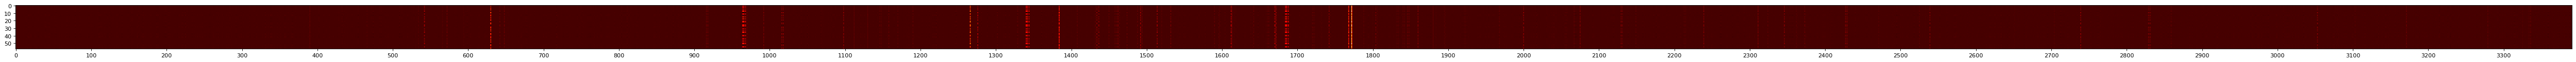

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, MultipleLocator
figure(figsize=(80, 100), dpi=80)
ax = plt.gca()
x_major_locator = MultipleLocator(100)
y_major_locator = MultipleLocator(10)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.imshow(logits, cmap='hot')
plt.show()

In [8]:
# Get predicted reward for certain action
all_nodes = graph_39.all_nodes()
for i in range(len(all_nodes)):
    node = all_nodes[i]
    print(f"{i}: {graph_39.xfer_appliable(xfer=quartz_context.get_xfer_from_id(id=3259), node=node)}, {logits[i][3259].item():.6f}")
    # print(i, ": ", graph_39.xfer_appliable(xfer=quartz_context.get_xfer_from_id(id=3461), node=node))
    # print(logits[i])

0: False, -0.000483
1: False, -0.000624
2: False, -0.000211
3: False, -0.000631
4: False, -0.000320
5: False, 0.000274
6: False, -0.000405
7: False, -0.000552
8: False, -0.000589
9: False, -0.000323
10: False, -0.000337
11: False, -0.000581
12: False, 0.001235
13: False, 0.001516
14: False, 0.000777
15: False, -0.000633
16: False, -0.000212
17: False, -0.000628
18: False, -0.000320
19: False, 0.000276
20: False, -0.000410
21: False, -0.000562
22: False, -0.000590
23: False, 0.001450
24: False, -0.000336
25: False, 0.001179
26: False, -0.000586
27: False, -0.000646
28: False, 0.001232
29: False, 0.001445
30: False, -0.000323
31: False, -0.000639
32: False, -0.000357
33: False, 0.000237
34: False, -0.000402
35: False, -0.000590
36: False, -0.000596
37: False, 0.001491
38: False, -0.000322
39: False, 0.001561
40: False, -0.000541
41: False, 0.001376
42: False, 0.001519
43: False, 0.000710
44: False, -0.000643
45: False, -0.000327
46: False, -0.000639
47: False, -0.000357
48: False, 0.0002